## Part 2: Supervised Baseline (Feedforward Network)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Train VAE and Apply Conformal predicitons.

In [77]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, auc,
    roc_curve, precision_recall_curve
)

In [111]:
# ----------------------------
# Config
# ----------------------------
CSV_PATH = "creditcard.csv"   # <-- put your path here
RANDOM_STATE = 42

# Global split: main/calib/test
MAIN_FRAC  = 0.70
CALIB_FRAC = 0.10
TEST_FRAC  = 0.20

# VAE training split inside main-legit
VAE_VAL_FRAC = 0.20

# VAE hyperparams
BATCH_SIZE = 128
SCORE_BATCH_SIZE = 256
LR = 3e-4
WEIGHT_DECAY = 1e-5

EPOCHS = 40
PATIENCE = 20

latent_dims = [8] #[2, 4, 8]
betas = [0.5]#, 1.0]

PARAM_GRID = [{"latent_dim": ld, "beta": b} for ld in latent_dims for b in betas]


OUT_DIR = "outputs_vae_conformal"
os.makedirs(OUT_DIR, exist_ok=True)

# Reproducibility
def seed_everything(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [112]:
# ----------------------------
# 1) Load + Split data
# ----------------------------
df = pd.read_csv(CSV_PATH)

y = df["Class"].astype(int).values
X = df.drop(columns=["Class"]).values.astype(np.float32)

n = len(df)
print(f"Loaded: n={n}, fraud_rate={y.mean():.5f}")

# Global split: D_main, D_calib, D_test (stratified)
test_size_temp = 1.0 - MAIN_FRAC
X_main, X_temp, y_main, y_temp = train_test_split(
    X, y, test_size=test_size_temp, stratify=y, random_state=RANDOM_STATE
)

# Split temp into calib and test
# temp fraction = CALIB_FRAC + TEST_FRAC
calib_in_temp = CALIB_FRAC / (CALIB_FRAC + TEST_FRAC)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=(1.0 - calib_in_temp),
    stratify=y_temp, random_state=RANDOM_STATE
)

print("\nGlobal splits:")
print(f"  D_main : {len(X_main)} (fraud_rate={y_main.mean():.5f})")
print(f"  D_calib: {len(X_calib)} (fraud_rate={y_calib.mean():.5f})")
print(f"  D_test : {len(X_test)} (fraud_rate={y_test.mean():.5f})")

# For VAE: use only legitimate transactions from D_main
X_main_legit = X_main[y_main == 0]
print(f"\nD_main_legit: {len(X_main_legit)}")

X_train_vae, X_val_vae = train_test_split(
    X_main_legit, test_size=VAE_VAL_FRAC, random_state=RANDOM_STATE
)

# Calibration for conformal: ONLY legitimate from D_calib (by ground-truth label)
X_calib_legit = X_calib[y_calib == 0]
print(f"D_calib_legit (for CP): {len(X_calib_legit)}")

# Standardize using ONLY VAE train-legit to avoid any test leakage
scaler = StandardScaler()
scaler.fit(X_train_vae)

X_train_vae_s = scaler.transform(X_train_vae).astype(np.float32)
X_val_vae_s   = scaler.transform(X_val_vae).astype(np.float32)

X_calib_legit_s = scaler.transform(X_calib_legit).astype(np.float32)
X_test_s        = scaler.transform(X_test).astype(np.float32)


Loaded: n=284807, fraud_rate=0.00173

Global splits:
  D_main : 199364 (fraud_rate=0.00173)
  D_calib: 28480 (fraud_rate=0.00172)
  D_test : 56963 (fraud_rate=0.00174)

D_main_legit: 199020
D_calib_legit (for CP): 28431


In [113]:
# ----------------------------
# Torch Dataset / Loader
# ----------------------------
def data_loader(X, batch_size=BATCH_SIZE, shuffle=True):
    torch_loader = DataLoader(
        torch.tensor(X, dtype=torch.float32), 
        batch_size=batch_size, 
        shuffle=shuffle,
        num_workers=0, 
        pin_memory=(device.type == "cuda")
    )
    return torch_loader

train_loader = data_loader(X_train_vae_s, BATCH_SIZE)
val_loader = data_loader(X_val_vae_s, BATCH_SIZE)

In [114]:
# ----------------------------
# 2) VAE definition + training utilities
# ----------------------------
class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, dropout_p: float = 0.2):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Vinay et al. style (for ~29 dims): input -> 20 -> 15 -> latent (symmetric decoder)
        h1, h2 = 32, 16

        # encoder
        self.enc_fc1 = nn.Linear(input_dim, h1)
        self.enc_bn1 = nn.BatchNorm1d(h1)
        self.enc_do1 = nn.Dropout(p=dropout_p)

        self.enc_fc2 = nn.Linear(h1, h2)
        self.enc_bn2 = nn.BatchNorm1d(h2)
        self.enc_do2 = nn.Dropout(p=dropout_p)

        self.fc_mu = nn.Linear(h2, latent_dim)
        self.fc_logvar = nn.Linear(h2, latent_dim)

        # decoder
        self.dec_fc1 = nn.Linear(latent_dim, h2)
        self.dec_bn1 = nn.BatchNorm1d(h2)

        self.dec_fc2 = nn.Linear(h2, h1)
        self.dec_bn2 = nn.BatchNorm1d(h1)

        self.dec_fc3 = nn.Linear(h1, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_fc1(x)))
        h = self.enc_do1(h)
        h = F.relu(self.enc_bn2(self.enc_fc2(h)))
        h = self.enc_do2(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_bn1(self.dec_fc1(z)))
        h = F.relu(self.dec_bn2(self.dec_fc2(h)))
        return self.dec_fc3(h)  # linear for standardized continuous features

    def forward(self, x, deterministic: bool = False):
        mu, logvar = self.encode(x)
        z = mu if deterministic else self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss(recon, x, mu, logvar, beta=1.0):
    recon_loss = ((recon - x) ** 2).mean(dim=1).sum()  # per-sample mse -> mean
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_loss + beta * kl
    return total, recon_loss, kl


def eval_epoch(model, loader, beta=1.0):
    with torch.no_grad():
        model.eval()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0
        for x in loader:
            x = x.to(device)
            recon, mu, logvar = model(x, deterministic=True)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta)
            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs
    return tot / n, rec / n, klv / n

In [115]:
def train_vae(model, train_loader, val_loader, epochs, lr, weight_decay, patience, beta=1.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_total": [], "train_recon": [], "train_kl": [],
        "val_total": [], "val_recon": [], "val_kl": []
    }

    best_val_recon = float("inf")
    best_val_total = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    warmup_epochs = 10  # KL warmup

    for epoch in tqdm(range(1, epochs + 1), desc="epochs", leave=True):
        model.train()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0

        beta_t = beta * min(1.0, epoch / warmup_epochs)

        for x in train_loader:
            x = x.to(device)
            optim.zero_grad(set_to_none=True)

            recon, mu, logvar = model(x)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta_t)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # clipping grad
            optim.step()

            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs

        train_total = tot / n
        train_recon = rec / n
        train_kl = klv / n

        val_total, val_recon, val_kl = eval_epoch(model, val_loader, beta)

        history["train_total"].append(train_total)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["val_total"].append(val_total)
        history["val_recon"].append(val_recon)
        history["val_kl"].append(val_kl)
        
        if epoch == 1 or epoch % 3 == 0 or epoch == epochs:
            print(
                f"epoch {epoch:03d} | "
                f"train total={train_total:.3f} recon={train_recon:.3f} kl={train_kl:.3f} | "
                f"val total={val_total:.3f} recon={val_recon:.3f} kl={val_kl:.3f}"
            )

        # Early stopping criterion for grid search:
        # prioritize val_recon (since anomaly score uses recon MSE), tie-break with val_total
        improved = (val_recon < best_val_recon - 1e-7) or (
            abs(val_recon - best_val_recon) <= 1e-7 and val_total < best_val_total - 1e-7
        )
        if improved:
            best_val_recon = val_recon
            best_val_total = val_total
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} (val_recon={best_val_recon:.3f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, best_epoch, best_val_recon, best_val_total

In [116]:
# ----------------------------
# 2b) Grid search (<= 5 runs)
# ----------------------------
input_dim = X_train_vae.shape[1]
best = None  # will store dict with model + params + stats

for i, cfg in enumerate(PARAM_GRID, start=1):
    seed_everything(RANDOM_STATE + i)  # stable but different init per config
    latent_dim = cfg["latent_dim"]
    beta = cfg["beta"]

    print(f"\n--- Config {i}/{len(PARAM_GRID)}: latent_dim={latent_dim}, beta={beta} ---") 
    model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)

    hist, be, val_recon_best, val_total_best = train_vae(
        model, train_loader, val_loader,
        beta=beta, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE
    )

    summary = {
        "cfg": cfg,
        "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "history": hist,
        "best_epoch": be,
        "best_val_recon": val_recon_best,
        "best_val_total": val_total_best,
    }

    if best is None:
        best = summary
    else:
        # choose best by val_recon, tie-break with val_total
        improved = (summary["best_val_recon"] < best["best_val_recon"] - 1e-7) or (
            abs(summary["best_val_recon"] - best["best_val_recon"]) <= 1e-7 and
            summary["best_val_total"] < best["best_val_total"] - 1e-7
        )
        if improved:
            best = summary

print("\n====================")
print("Best config selected\n")
print(f"  latent_dim={best['cfg']['latent_dim']}, beta={best['cfg']['beta']}")
print(f"  best_epoch={best['best_epoch']}")
print(f"  best_val_recon={best['best_val_recon']:.3f}")
print(f"  best_val_total={best['best_val_total']:.3f}")

# Restore best model
vae = VAE(input_dim=input_dim, latent_dim=best["cfg"]["latent_dim"]).to(device)
vae.load_state_dict(best["model_state"])
history = best["history"]
BETA = best["cfg"]["beta"]



--- Config 1/1: latent_dim=8, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:09<06:27,  9.94s/it]

epoch 001 | train total=118.350 recon=118.316 kl=0.691 | val total=103.453 recon=102.758 kl=1.390


epochs:   8%|▊         | 3/40 [00:28<05:51,  9.49s/it]

epoch 003 | train total=93.850 recon=93.384 kl=3.104 | val total=83.366 recon=81.931 kl=2.868


epochs:  15%|█▌        | 6/40 [00:55<05:12,  9.19s/it]

epoch 006 | train total=85.608 recon=84.495 kl=3.710 | val total=72.208 recon=70.525 kl=3.365


epochs:  22%|██▎       | 9/40 [01:24<04:55,  9.55s/it]

epoch 009 | train total=82.187 recon=80.693 kl=3.320 | val total=65.730 recon=64.164 kl=3.132


epochs:  30%|███       | 12/40 [01:55<04:41, 10.05s/it]

epoch 012 | train total=80.389 recon=78.840 kl=3.099 | val total=69.656 recon=68.418 kl=2.477


epochs:  38%|███▊      | 15/40 [02:28<04:25, 10.62s/it]

epoch 015 | train total=79.057 recon=77.525 kl=3.063 | val total=63.168 recon=61.762 kl=2.813


epochs:  45%|████▌     | 18/40 [03:02<04:07, 11.23s/it]

epoch 018 | train total=77.916 recon=76.400 kl=3.031 | val total=62.529 recon=61.165 kl=2.729


epochs:  52%|█████▎    | 21/40 [03:38<03:40, 11.58s/it]

epoch 021 | train total=77.139 recon=75.637 kl=3.004 | val total=60.897 recon=59.511 kl=2.773


epochs:  60%|██████    | 24/40 [04:13<03:06, 11.65s/it]

epoch 024 | train total=76.056 recon=74.554 kl=3.004 | val total=59.672 recon=58.292 kl=2.761


epochs:  68%|██████▊   | 27/40 [04:48<02:31, 11.66s/it]

epoch 027 | train total=75.158 recon=73.668 kl=2.978 | val total=58.078 recon=56.670 kl=2.818


epochs:  75%|███████▌  | 30/40 [05:21<01:52, 11.30s/it]

epoch 030 | train total=74.594 recon=73.110 kl=2.968 | val total=57.454 recon=56.056 kl=2.796


epochs:  82%|████████▎ | 33/40 [05:53<01:16, 10.96s/it]

epoch 033 | train total=73.833 recon=72.356 kl=2.955 | val total=56.362 recon=54.955 kl=2.813


epochs:  90%|█████████ | 36/40 [06:25<00:43, 10.82s/it]

epoch 036 | train total=73.258 recon=71.774 kl=2.967 | val total=56.683 recon=55.320 kl=2.725


epochs:  98%|█████████▊| 39/40 [07:00<00:11, 11.22s/it]

epoch 039 | train total=72.816 recon=71.339 kl=2.954 | val total=54.471 recon=53.052 kl=2.837


epochs: 100%|██████████| 40/40 [07:12<00:00, 10.80s/it]

epoch 040 | train total=72.802 recon=71.328 kl=2.948 | val total=54.127 recon=52.702 kl=2.852

Best config selected

  latent_dim=8, beta=0.5
  best_epoch=40
  best_val_recon=52.702
  best_val_total=54.127



Saved loss plots:
  outputs_vae_conformal\vae_loss_total_train_vs_val.png
  outputs_vae_conformal\vae_loss_recon_train_vs_val.png


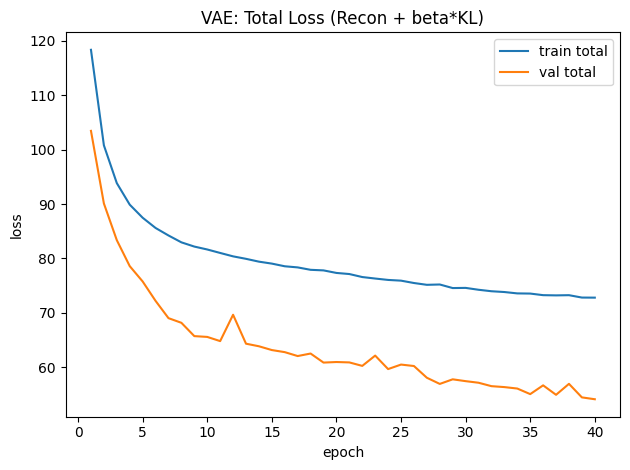

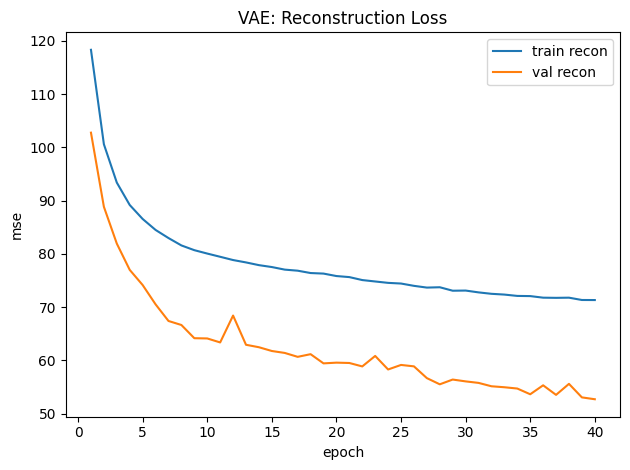

In [118]:
# ----------------------------
# Save 2 loss images for best run
# ----------------------------
epochs_r = np.arange(1, len(history["train_total"]) + 1)

plt.figure()
plt.plot(epochs_r, history["train_total"], label="train total")
plt.plot(epochs_r, history["val_total"], label="val total")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("VAE: Total Loss (Recon + beta*KL)")
plt.legend()
plt.tight_layout()
loss_total_path = os.path.join(OUT_DIR, "vae_loss_total_train_vs_val.png")
#plt.savefig(loss_total_path, dpi=200)
#plt.close()

plt.figure()
plt.plot(epochs_r, history["train_recon"], label="train recon")
plt.plot(epochs_r, history["val_recon"], label="val recon")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.title("VAE: Reconstruction Loss")
plt.legend()
plt.tight_layout()
loss_recon_path = os.path.join(OUT_DIR, "vae_loss_recon_train_vs_val.png")
#plt.savefig(loss_recon_path, dpi=200)
#plt.close()

print("\nSaved loss plots:")
print(f"  {loss_total_path}")
print(f"  {loss_recon_path}")


VAE score metrics on TEST (score = recon MSE):
  ROC-AUC = 0.942850
  PR-AUC  = 0.331386

Saved ROC/PR plots:
  outputs_vae_conformal\vae_roc_curve.png
  outputs_vae_conformal\vae_pr_curve.png


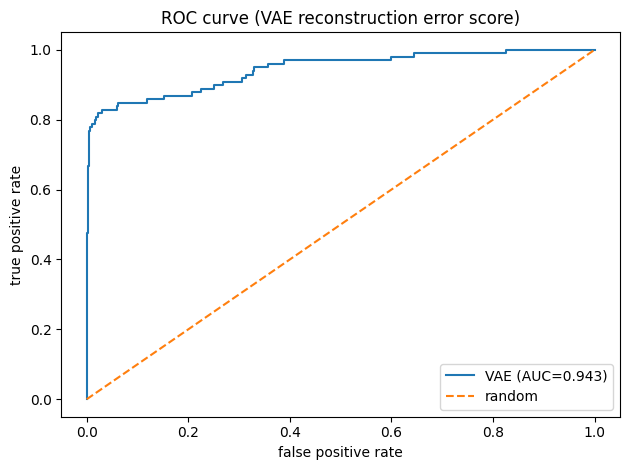

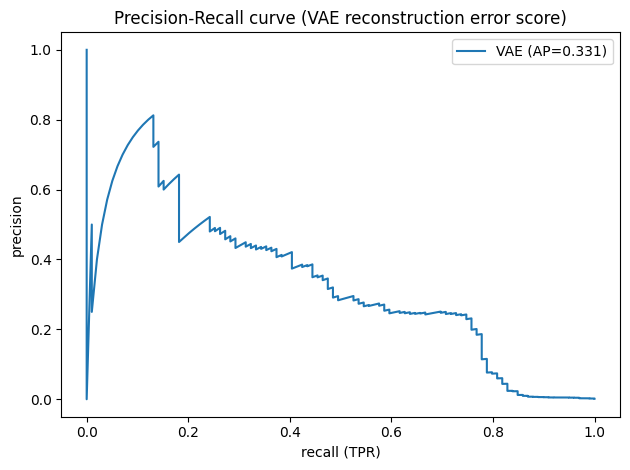

In [119]:
# ----------------------------
# Helper: compute VAE reconstruction error scores
# ----------------------------
def vae_scores_mse(model, X_np, batch_size=SCORE_BATCH_SIZE):
    with torch.no_grad():
        """Return per-sample reconstruction MSE scores."""
        model.eval()
        X_loaded = data_loader(X_np, batch_size=batch_size, shuffle=False)
        scores = []
        for x in X_loaded:
            x = x.to(device)
            recon, _, _ = model(x, deterministic=True)
            s = ((x - recon) ** 2).mean(dim=1)  # per-sample MSE
            scores.append(s.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

# ----------------------------
# 3) ROC-AUC + PR-AUC curves for VAE scores on TEST
# ----------------------------
scores_test = vae_scores_mse(vae, X_test_s)
roc_auc = roc_auc_score(y_test, scores_test)
pr_auc  = average_precision_score(y_test, scores_test)

print(f"\nVAE score metrics on TEST (score = recon MSE):")
print(f"  ROC-AUC = {roc_auc:.6f}")
print(f"  PR-AUC  = {pr_auc:.6f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, scores_test)
plt.figure()
plt.plot(fpr, tpr, label=f"VAE (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="random")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve (VAE reconstruction error score)")
plt.legend()
plt.tight_layout()
roc_path = os.path.join(OUT_DIR, "vae_roc_curve.png")
#plt.savefig(roc_path, dpi=200)
#plt.close()

# PR curve
precision, recall, _ = precision_recall_curve(y_test, scores_test)
plt.figure()
plt.plot(recall, precision, label=f"VAE (AP={pr_auc:.3f})")
plt.xlabel("recall (TPR)")
plt.ylabel("precision")
plt.title("Precision-Recall curve (VAE reconstruction error score)")
plt.legend()
plt.tight_layout()
pr_path = os.path.join(OUT_DIR, "vae_pr_curve.png")
#plt.savefig(pr_path, dpi=200)
#plt.close()

print("\nSaved ROC/PR plots:")
print(f"  {roc_path}")
print(f"  {pr_path}")

## Conformal predictions

In [109]:
import numpy as np
import math

# ============================================================
# Conformal Outlier Detection (Section 6.3 of the article)
# Score: s(x) = MSE(x, x_hat)  (larger => more outlier)
# Calibrate on CLEAN data only (legit: y=0).
# Threshold: qhat = Quantile(s1..sn; ceil((n+1)(1-alpha))/n)
# Decision: outlier iff s(x) > qhat
# ============================================================

def conformal_outlier_threshold(scores_clean: np.ndarray, alpha: float) -> float:
    """
    Article (Sec 6.3): qhat = Quantile(s1..sn; ceil((n+1)(1-alpha))/n).
    Implemented as the k-th smallest score with k = ceil((n+1)(1-alpha)).
    """
    s = np.sort(np.asarray(scores_clean).reshape(-1))
    n = len(s)
    k = int(math.ceil((n + 1) * (1 - alpha)))
    k = min(max(k, 1), n)                   
    return float(s[k - 1])

def conformal_pvalues_upper_tail(scores_clean: np.ndarray, scores_x: np.ndarray) -> np.ndarray:
    """
    Conformal p-values for outlier detection (upper-tail):
    p(x) = (1 + #{i: s_i >= s(x)}) / (n + 1)
    Decision "outlier at level alpha" <=> p(x) <= alpha.
    """
    s = np.asarray(scores_clean).reshape(-1)
    t = np.asarray(scores_x).reshape(-1)
    n = len(s)
    
    # count how many calibration scores are >= each test score
    ge = (s[None, :] >= t[:, None]).sum(axis=1)
    return (1.0 + ge) / (n + 1.0)

# scores on CLEAN calibration set (legit only)
scores_calib_legit = vae_scores_mse(vae, X_calib_legit_s) 

# scores on test set (contains both classes; used only for evaluation)
scores_test = vae_scores_mse(vae, X_test_s)

alphas = [0.001, 0.01, 0.05, 0.1]
taus = {a: conformal_outlier_threshold(scores_calib_legit, a) for a in alphas}

print("Conformal outlier thresholds (calibrated on CLEAN legit only):")
for a in alphas:
    print(f"  alpha={a:.2%} -> qhat={taus[a]:.6f}")

def confusion_from_scores(y_true: np.ndarray, scores: np.ndarray, tau: float):
    y_pred = (scores > tau).astype(int)  # 1 = flagged as outlier/fraud
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fpr = fp / (fp + tn + 1e-12)
    tpr = tp / (tp + fn + 1e-12)
    return fpr, tpr, tn, fp, fn, tp

print("\nTest performance at conformal thresholds:")
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, tn, fp, fn, tp = confusion_from_scores(y_test, scores_test, tau)
    print(
        f"  alpha={a:.2%} | qhat={tau:.6f} | "
        f"FPR(test)={fpr_hat:.4%} | TPR(test)={tpr_hat:.4%} | "
        f"TN={tn} FP={fp} FN={fn} TP={tp}"
    )

Conformal outlier thresholds (calibrated on CLEAN legit only):
  alpha=0.10% -> qhat=18.255148
  alpha=1.00% -> qhat=3.269839
  alpha=5.00% -> qhat=1.369713
  alpha=10.00% -> qhat=1.060606

Test performance at conformal thresholds:
  alpha=0.10% | qhat=18.255148 | FPR(test)=0.1073% | TPR(test)=33.3333% | TN=56803 FP=61 FN=66 TP=33
  alpha=1.00% | qhat=3.269839 | FPR(test)=0.9127% | TPR(test)=76.7677% | TN=56345 FP=519 FN=23 TP=76
  alpha=5.00% | qhat=1.369713 | FPR(test)=5.0049% | TPR(test)=80.8081% | TN=54018 FP=2846 FN=19 TP=80
  alpha=10.00% | qhat=1.060606 | FPR(test)=9.8991% | TPR(test)=83.8384% | TN=51235 FP=5629 FN=16 TP=83


## Plots

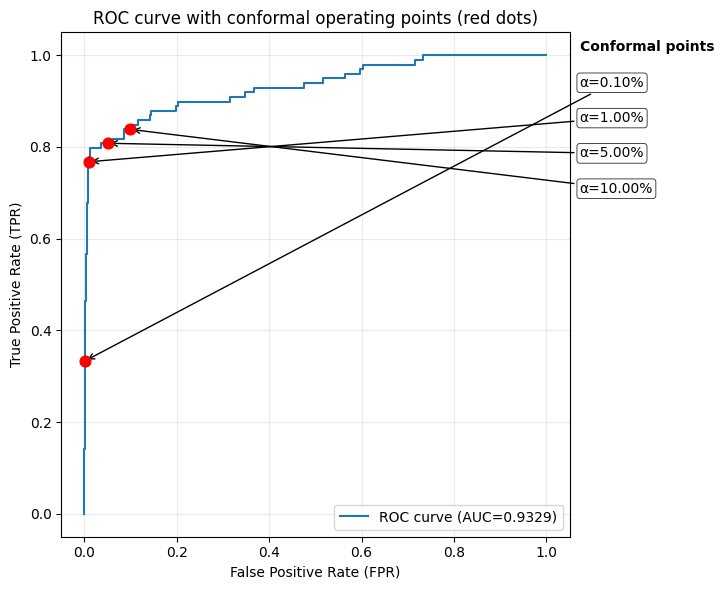

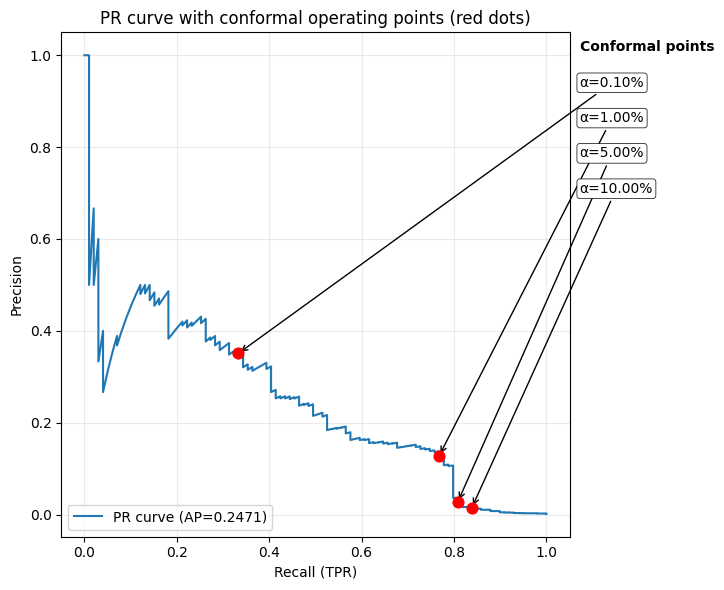

In [110]:
# Plot ROC/PR curves + conformal operating points
def confusion_rates_at_tau(y_true, scores, tau):
    """Decision rule: predict fraud/outlier if score > tau."""
    y_pred = (scores > tau).astype(int)

    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))

    fpr = fp / (fp + tn + 1e-12)
    tpr = tp / (tp + fn + 1e-12)
    precision = tp / (tp + fp + 1e-12)

    return fpr, tpr, precision, tn, fp, fn, tp


def add_annotation_legend_with_arrows(ax, points, title=None,
                                      x_text=1.02, y_top=0.90, y_step=0.07):
    """
    points: list of (label, x_pt, y_pt) in DATA coords.
    Places labels outside the right of the axes (axes fraction coords),
    draws arrows to corresponding data points.
    """
    if title is not None:
        ax.text(
            x_text, min(0.98, y_top + 0.07), title,
            transform=ax.transAxes, ha="left", va="center",
            fontsize=10, fontweight="bold", clip_on=False
        )

    for i, (lab, x_pt, y_pt) in enumerate(points):
        y_txt = y_top - i * y_step
        ax.annotate(
            lab,
            xy=(x_pt, y_pt), xycoords="data",
            xytext=(x_text, y_txt), textcoords="axes fraction",
            ha="left", va="center",
            arrowprops=dict(arrowstyle="->", lw=1.0),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.5),
            annotation_clip=False
        )


# ============================
# ROC curve
# ============================
fpr_curve, tpr_curve, _ = roc_curve(y_test, scores_test)
roc_auc = auc(fpr_curve, tpr_curve)

plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.plot(fpr_curve, tpr_curve, label=f"ROC curve (AUC={roc_auc:.4f})")

# conformal operating points (red dots)
roc_points = []
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, _, *_ = confusion_rates_at_tau(y_test, scores_test, tau)
    ax.scatter([fpr_hat], [tpr_hat], c="red", s=60, zorder=5)
    roc_points.append((f"α={a:.2%}", fpr_hat, tpr_hat))

# sort by x so arrows cross less
roc_points.sort(key=lambda t: t[1])

add_annotation_legend_with_arrows(
    ax, roc_points, title="Conformal points", x_text=1.02, y_top=0.90, y_step=0.07
)

ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("ROC curve with conformal operating points (red dots)")
ax.grid(True, alpha=0.25)
ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 0.82, 1])  # leave space on right for annotation legend
roc_path = os.path.join(OUT_DIR, "roc_with_conformal_operating_points.png")
#plt.savefig(roc_path, dpi=200, bbox_inches="tight")
#plt.close()


# ============================
# PR curve
# ============================
precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores_test)
ap = average_precision_score(y_test, scores_test)

plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.plot(recall_curve, precision_curve, label=f"PR curve (AP={ap:.4f})")

pr_points = []
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, prec_hat, *_ = confusion_rates_at_tau(y_test, scores_test, tau)
    recall_hat = tpr_hat
    ax.scatter([recall_hat], [prec_hat], c="red", s=60, zorder=5)
    pr_points.append((f"α={a:.2%}", recall_hat, prec_hat))

pr_points.sort(key=lambda t: t[1])

add_annotation_legend_with_arrows(
    ax, pr_points, title="Conformal points", x_text=1.02, y_top=0.90, y_step=0.07
)

ax.set_xlabel("Recall (TPR)")
ax.set_ylabel("Precision")
ax.set_title("PR curve with conformal operating points (red dots)")
ax.grid(True, alpha=0.25)
ax.legend(loc="lower left")

plt.tight_layout(rect=[0, 0, 0.82, 1])
pr_path = os.path.join(OUT_DIR, "pr_with_conformal_operating_points.png")
#plt.savefig(pr_path, dpi=200, bbox_inches="tight")
#plt.close()